In [2]:
import sys
sys.path.append('./scripts/')
from puddle_world import *
import itertools 
import collections 
from copy import copy

In [3]:
class DynamicProgramming: 
    def __init__(self, widths, goal, puddles, time_interval, sampling_num, \
                 puddle_coef=100.0, lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T): 
        self.pose_min = np.r_[lowerleft, 0]
        self.pose_max = np.r_[upperright, math.pi*2]
        self.widths = widths
        self.goal = goal
        
        self.index_nums = ((self.pose_max - self.pose_min)/self.widths).astype(int)
        nx, ny, nt = self.index_nums
        self.indexes = list(itertools.product(range(nx), range(ny), range(nt)))
        
        self.value_function, self.final_state_flags =  self.init_value_function() 
        self.policy = self.init_policy()
        self.actions = list(set([tuple(self.policy[i]) for i in self.indexes]))
        print(self.actions)
        
        self.state_transition_probs = self.init_state_transition_probs(time_interval, sampling_num)
        self.depths = self.depth_means(puddles, sampling_num)
        
        self.time_interval = time_interval
        self.puddle_coef = puddle_coef
        
    def value_iteration_sweep(self): #追加
        max_delta = 0.0
        for index in self.indexes:
            if not self.final_state_flags[index]:
                max_q = -1e100
                max_a = None
                qs = [self.action_value(a, index) for a in self.actions] #全行動の行動価値を計算
                max_q = max(qs)                               #最大の行動価値
                max_a = self.actions[np.argmax(qs)]   #最大の行動価値を与える行動
                
                delta = abs(self.value_function[index] - max_q)            #変化量
                max_delta = delta if delta > max_delta else max_delta #スイープ中で最大の変化量の更新
                
                self.value_function[index] = max_q      #価値の更新
                self.policy[index] = np.array(max_a).T  #方策の更新
            
        return max_delta        
        
    def policy_evaluation_sweep(self):   
        max_delta = 0.0
        for index in self.indexes:
            if not self.final_state_flags[index]:
                q = self.action_value(tuple(self.policy[index]), index)
                
                delta = abs(self.value_function[index] - q)
                max_delta = delta if delta > max_delta else max_delta
                
                self.value_function[index] = q
            
        return max_delta
    
    def action_value(self, action, index, out_penalty=True): 
        value = 0.0
        for delta, prob in self.state_transition_probs[(action, index[2])]: 
            after, out_reward = self.out_correction(np.array(index).T + delta)
            after = tuple(after)
            reward = - self.time_interval * self.depths[(after[0], after[1])] * self.puddle_coef - self.time_interval + out_reward*out_penalty
            value += (self.value_function[after] + reward) * prob

        return value
            
    def out_correction(self, index): #変更
        out_reward = 0.0
        index[2] = (index[2] + self.index_nums[2])%self.index_nums[2] #方角の処理
        
        for i in range(2):
            if index[i] < 0:
                index[i] = 0
                out_reward = -1e100
            elif index[i] >= self.index_nums[i]:
                index[i] = self.index_nums[i]-1
                out_reward = -1e100
                
        return index, out_reward
        
    def depth_means(self, puddles, sampling_num):
        ###セルの中の座標を均等にsampling_num**2点サンプリング###
        dx = np.linspace(0, self.widths[0], sampling_num) 
        dy = np.linspace(0, self.widths[1], sampling_num)
        samples = list(itertools.product(dx, dy))
        
        tmp = np.zeros(self.index_nums[0:2]) #深さの合計が計算されて入る
        for xy in itertools.product(range(self.index_nums[0]), range(self.index_nums[1])):
            for s in samples:
                pose = self.pose_min + self.widths*np.array([xy[0], xy[1], 0]).T + np.array([s[0], s[1], 0]).T #セルの中心の座標
                for p in puddles:
                    tmp[xy] += p.depth*p.inside(pose) #深さに水たまりの中か否か（1 or 0）をかけて足す
                        
            tmp[xy] /= sampling_num**2 #深さの合計から平均値に変換
                       
        return tmp
    
    def init_state_transition_probs(self, time_interval, sampling_num):
        ###セルの中の座標を均等にsampling_num**3点サンプリング###
        dx = np.linspace(0.001, self.widths[0]*0.999, sampling_num) #隣のセルにはみ出さないように端を避ける
        dy = np.linspace(0.001, self.widths[1]*0.999, sampling_num)
        dt = np.linspace(0.001, self.widths[2]*0.999, sampling_num)
        samples = list(itertools.product(dx, dy, dt))
        
        ###各行動、各方角でサンプリングした点を移動してインデックスの増分を記録###
        tmp = {}
        for a in self.actions:
            for i_t in range(self.index_nums[2]):
                transitions = []
                for s in samples:
                    before = np.array([s[0], s[1], s[2] + i_t*self.widths[2]]).T + self.pose_min  #遷移前の姿勢
                    before_index = np.array([0, 0, i_t]).T                                                      #遷移前のインデックス
                
                    after = IdealRobot.state_transition(a[0], a[1], time_interval, before)   #遷移後の姿勢
                    after_index = np.floor((after - self.pose_min)/self.widths).astype(int)   #遷移後のインデックス
                    
                    transitions.append(after_index - before_index)                                  #インデックスの差分を追加
                    
                unique, count = np.unique(transitions, axis=0, return_counts=True)   #集計（どのセルへの遷移が何回か）
                probs = [c/sampling_num**3 for c in count]                   #サンプル数で割って確率にする
                tmp[a,i_t] = list(zip(unique, probs))
                
        return tmp
        
    def init_policy(self):
        tmp = np.zeros(np.r_[self.index_nums,2]) #制御出力が2次元なので、配列の次元を4次元に
        for index in self.indexes:
            center = self.pose_min + self.widths*(np.array(index).T + 0.5)  #セルの中心の座標
            tmp[index] = PuddleIgnoreAgent.policy(center, self.goal)
            
        return tmp
        
    def init_value_function(self): 
        v = np.empty(self.index_nums) #全離散状態を要素に持つ配列を作成
        f = np.zeros(self.index_nums) 
        
        for index in self.indexes:
            f[index] = self.final_state(np.array(index).T)
            v[index] = self.goal.value if f[index] else -100.0
                
        return v, f
        
    def final_state(self, index):
        x_min, y_min, _ = self.pose_min + self.widths*index          #xy平面で左下の座標
        x_max, y_max, _ = self.pose_min + self.widths*(index + 1) #右上の座標（斜め上の離散状態の左下の座標）
        
        corners = [[x_min, y_min, _], [x_min, y_max, _], [x_max, y_min, _], [x_max, y_max, _] ] #4隅の座標
        return all([self.goal.inside(np.array(c).T) for c in corners ])

In [4]:
import seaborn as sns   ###dp2exec

puddles = [Puddle((-2, 0), (0, 2), 0.1), Puddle((-0.5, -2), (2.5, 1), 0.1)] 
dp = DynamicProgramming(np.array([0.2, 0.2, math.pi/18]).T, Goal(-3,-3), puddles, 0.1, 10) 
counter = 0 #スイープの回数

[(1.0, 0.0), (0.0, 2.0), (0.0, -2.0)]


In [5]:
delta = 1e100

while delta > 0.01: 
    delta = dp.value_iteration_sweep()
    counter += 1
    print(counter, delta)

1 54.12620000000001
2 52.540741168171046
3 27.091733819809406
4 24.39709159867244
5 19.958651189319355
6 18.650774772789774
7 16.225165985426358
8 15.781952896530726
9 14.141842898129966
10 13.270731255868625
11 12.497393357370377
12 11.732667732727286
13 11.238231423228726
14 10.004223508516631
15 9.156190280697437
16 8.713907413060952
17 8.311729090172499
18 8.003867161321743
19 7.670727509824289
20 7.386915336036694
21 7.137289788630262
22 6.918135696700659
23 6.8608402702996045
24 6.710750534605353
25 6.55310883437339
26 6.49657837154642
27 6.179852073016036
28 6.10790245886345
29 5.840942349519494
30 5.702705930557386
31 5.593934283599893
32 5.45512894903807
33 5.332177442427394
34 5.235898193331209
35 5.145362578982962
36 5.059359919967868
37 4.977445179187143
38 4.900195466992585
39 4.827392749510928
40 4.684750759563244
41 4.479900776997326
42 4.223964280239741
43 3.9409767020735416
44 3.8374174227343474
45 3.7333358234886873
46 3.5736119095796255
47 3.370378819190506
48 3.1652

In [6]:
with open("./data/dp_policy.txt", "w") as f:  ###dp2writepolicy
    for index in dp.indexes:
        p = dp.policy[index]
        f.write("{} {} {} {} {}\n".format(index[0], index[1], index[2], p[0], p[1]))
        
with open("./data/dp_value.txt", "w") as f:
    for index in dp.indexes:
        p = dp.value_function[index]
        f.write("{} {} {} {}\n".format(index[0], index[1], index[2], p))

<IPython.core.display.Javascript object>


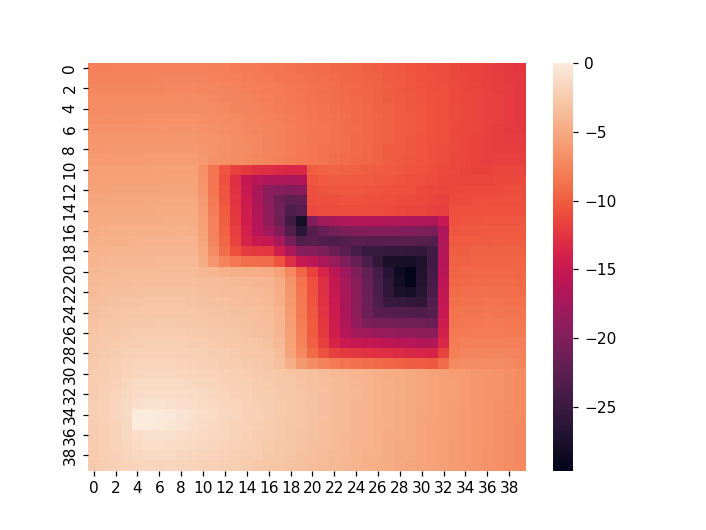

In [12]:
v = dp.value_function[:, :, 18]  ###dp1valuedraw
sns.heatmap(np.rot90(v), square=False)
plt.show()

<IPython.core.display.Javascript object>


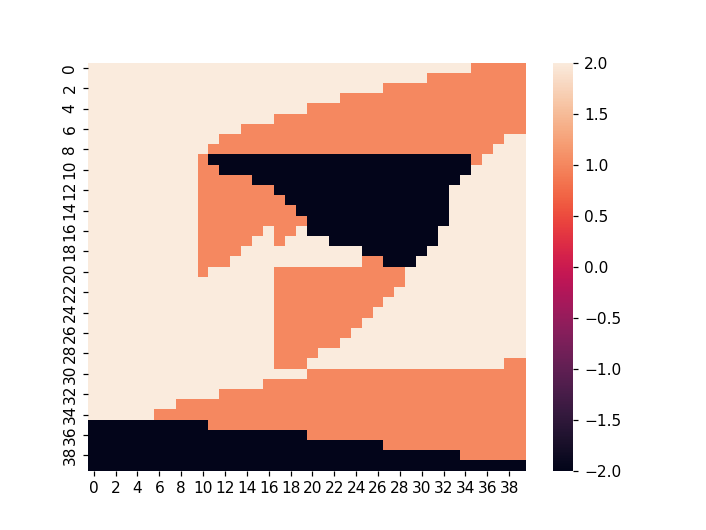

In [13]:
p = np.zeros(dp.index_nums) ###dp1policydraw
for i in dp.indexes:
    p[i] = sum(dp.policy[i]) #速度と角速度を足すと、1.0: 直進、2.0: 左回転、-2.0: 右回転になる

sns.heatmap(np.rot90(p[:, :, 18]), square=False) #180〜190[deg]の向きのときの行動を図示
plt.show()

In [9]:
class PolicyAgent(PuddleIgnoreAgent): 
    def __init__(self, time_interval, estimator, goal, puddle_coef=100, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                 lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T, policyfile="./data/dp_policy.txt"): 
        super().__init__(time_interval, estimator, goal, puddle_coef) 
        
        ###座標関連の変数をDynamicProgrammingから持ってくる###
        self.pose_min = np.r_[lowerleft, 0] 
        self.pose_max = np.r_[upperright, math.pi*2]
        self.widths = widths
        self.index_nums = ((self.pose_max - self.pose_min)/self.widths).astype(int)
        
        self.policyfile = policyfile
        self.policy_data = self.init_policy(self.index_nums)
        
    def init_policy(self, index_nums):
        tmp = np.zeros(np.r_[index_nums,2])
        for line in open(self.policyfile, "r"):
            d = line.split()
            tmp[int(d[0]), int(d[1]), int(d[2])] = [float(d[3]), float(d[4])]
            
        return tmp
    
    def to_index(self, pose, pose_min, index_nums , widths): #姿勢をインデックスに変えて正規化
        index = np.floor((pose - pose_min)/widths).astype(int)           #姿勢からインデックスに
        
        index[2] = (index[2] + index_nums[2]*1000)%index_nums[2] #角度の正規化
        for i in [0,1]:                                                                                   #端の処理（内側の座標の方策を使う）
            if index[i] < 0: index[i] = 0
            elif index[i] >= index_nums[i]: index[i] = index_nums[i] - 1
                
        return tuple(index) #ベクトルのままだとインデックスに使えないのでタプルに
    
    def policy(self, pose, goal=None): #姿勢から離散状態のインデックスを作って方策を参照して返すだけ                
        return self.policy_data[self.to_index(pose, self.pose_min, self.index_nums, self.widths)]

<IPython.core.display.Javascript object>


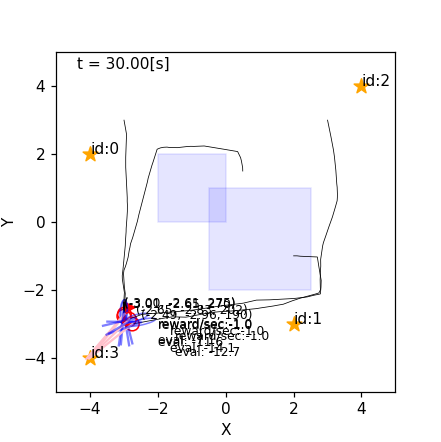

In [11]:
def trial():  ###dppolicyagentrun
    time_interval = 0.1
    world = PuddleWorld(30, time_interval, debug=False) 

    ## 地図を生成して3つランドマークを追加 ##
    m = Map()
    for ln in [(-4,2), (2,-3), (4,4), (-4,-4)]: m.append_landmark(Landmark(*ln))
    world.append(m)   

    ##ゴールの追加##
    goal = Goal(-3,-3)  #goalを変数に
    world.append(goal)
    
    ##水たまりの追加##
    world.append(Puddle((-2, 0), (0, 2), 0.1)) 
    world.append(Puddle((-0.5, -2), (2.5, 1), 0.1)) 

    ##4台のロボットを動かしてみる##   ##dppolicyagentrun
    init_poses = []
    for p in [[-3, 3, 0], [0.5, 1.5, 0], [3, 3, 0], [2, -1, 0]]:
        init_pose = np.array(p).T
    
        kf = KalmanFilter(m, init_pose)
        a = PolicyAgent(time_interval, kf, goal, policyfile="./data/dp_policy.txt")
        r = Robot(init_pose, sensor=Camera(m, distance_bias_rate_stddev=0, direction_bias_stddev=0), 
              agent=a, color="red", bias_rate_stds=(0,0))

        world.append(r)
        
    world.draw()
    
trial()